# Project Overview:
The objective is to create a convolutional neural network (CNN) to identify metastatic cancer in small image patches taken from larger digital pathology scans. CNN will classify the images from the dataset into two classes, i.e. having cancer and not having cancer. The dataset consists of microscopic images of lymph node tissue. Each image has a resolution of 96x96 pixels, and the task will be to identify metastatic cancer tissue in a 32x32 pixel center region of the image. The identification of at least 1 pixel of tumor tissue would effectively label the image as positive. The train dataset consists of 220,025 images, while the test dataset contains 57,468 images.



# Setup and Load Data

In [5]:
# Load necessary libraries
from glob import glob 
import numpy as np
import pandas as pd
import os
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc 

In [6]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [7]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [8]:
# Creating paths for train and test data
path = "../input/histopathologic-cancer-detection/" 
train_path = path + 'train/'
test_path = path + 'test/'

In [9]:
# Creating a dataframe from the train_path filenames and lables
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 
labels = pd.read_csv(path+"train_labels.csv") 
df = df.merge(labels, on = "id") 

In [10]:
# dataframe
df.head(5)

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,../input/histopathologic-cancer-detection/trai...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,../input/histopathologic-cancer-detection/trai...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,../input/histopathologic-cancer-detection/trai...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


In [11]:
# Dataframe info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.7+ MB


In [12]:
# Loading N images from df dataframe
def load_data(N,df):
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df['label'].to_numpy())[0:N]
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])     
    return X,y


In [13]:
# Loading 10000 images
N=10000
X,y = load_data(N=N,df=df) 

/tmp/ipykernel_29/1900582363.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/10000 [00:00<?, ?it/s]

# Exploratory Data Analysis (EDA) 

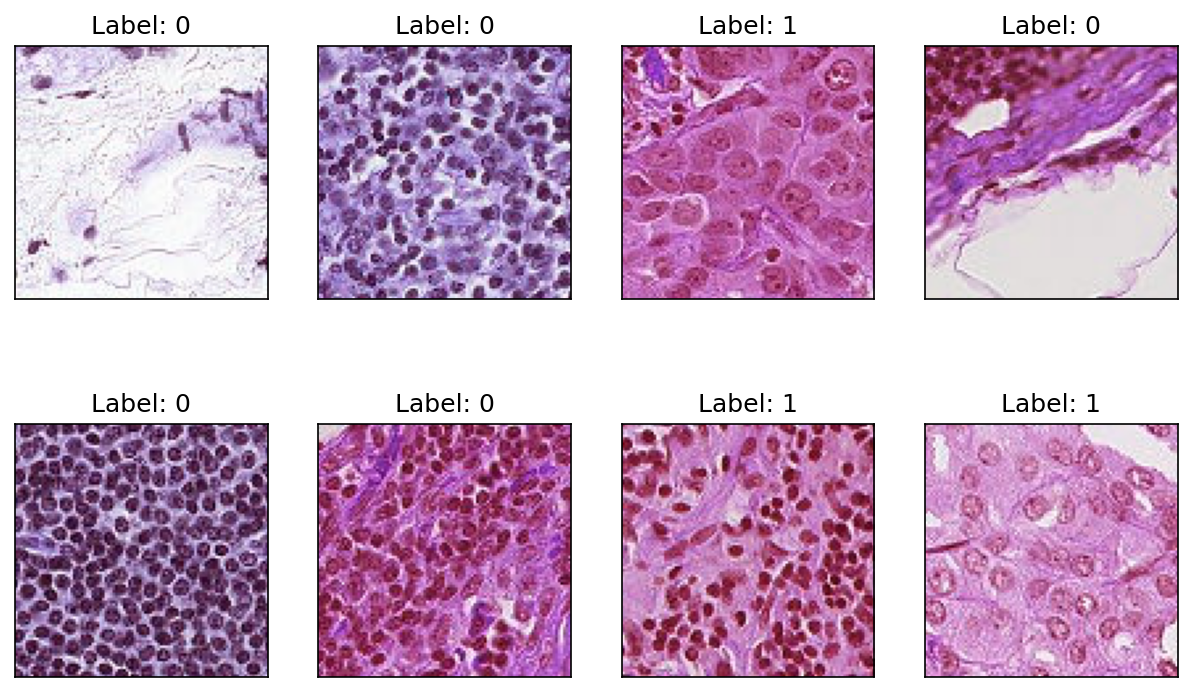

In [14]:
# Visualizing a set of random images
fig = plt.figure(figsize=(10, 6), dpi=150)
np.random.seed(42) 
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[]) 
    plt.imshow(X[idx]) 
    ax.set_title('Label: ' + str(y[idx]))  

The images above represent random examples of tissue with and without evidence of cancer. An image labeled as 0 represents tissue without cancer and an image labeled as 1 represents tissue with cancer. Upon visualizing several sets of random images, it seems that tissues with large white dots often warrant a positive label. From this, one could deduce that these large white dots are tumors.

Text(0, 0.5, 'Samples')

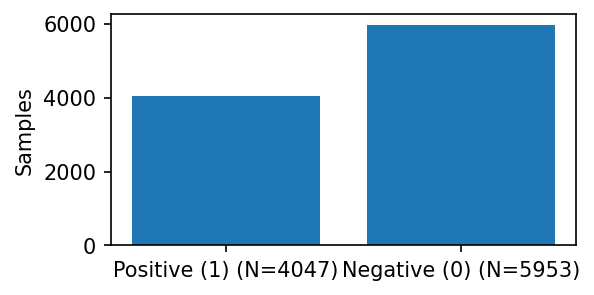

In [15]:
# Visualizing the distribution of positive and negative cases
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); 
plt.xticks([1,0],["Negative (0) (N={})".format((y==0).sum()),"Positive (1) (N={})".format((y==1).sum())]);
plt.ylabel("Samples")

Above, we can see the value counts of each label in the dataset. Overall, there are 5953 negative images and 4047 positive images. Nearly 60% of the dataset contains images of tissue with no cancer and 40% with cancer.

# Model Architecture
The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a subsampling layer. This pattern is repeated three times before the output feature maps are flattened and fed to a fully connected layer for interpretation and a final prediction. The final section of the architecture is often referred to as the classifier, whereas the convolutional and pooling layers earlier in the model are referred to as the feature extractor.

The architecture uses a smaller number of filters as the first hidden layer, specifically 32 filters each with the size of 96x96 pixels. After pooling (called a subsampling layer), another convolutional layer has many more filters, specifically 64 and 128 filters with a size of 96x96 pixels, again followed by pooling. In the repetition of these three blocks of convolution and pooling layers. 

Here is a summary of the architecture:

- Fixed-sized input images
- Group convolutional and pooling layers into blocks
- Repetition of convolutional-pooling blocks 
- Increase in the number of filters with the depth of the network
- Distinct feature extraction and classifier parts of the architecture


# Build Model

In [16]:
# Loading images from the training set
N = df["path"].size
X,y = load_data(N=N,df=df)

/tmp/ipykernel_29/1900582363.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/220025 [00:00<?, ?it/s]

In [17]:
# Splitting the data into train and validation sets
training_portion = 0.8 
split_idx = int(np.round(training_portion * y.shape[0])) 
np.random.seed(42) 

In [18]:
# Shuffling the data
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [20]:
# Building the model
# Parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

# Dropout for regularization, 0.3 for conv layers, 0.5 for dense layer
dropout_conv = 0.3
dropout_dense = 0.5

# Initializing the model
model = Sequential()

# Building the first conv block
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Building the second conv block
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Building the third conv block
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Building the dense layer
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

# Converting 0 to 1 using sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

In [21]:
# Compiling the model
batch_size = 50

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

I created a model with three convolutional layers and a dense layer. I used a batch size of 50, binary cross entropy and the Adam optimizer with a learning rate of 0.001.

# Training the Model 

In [22]:
# Training the model for 3 epochs
epochs = 3 
for epoch in range(epochs):
    iterations = np.floor(split_idx / batch_size).astype(int) 
    loss,acc = 0,0 
    with trange(iterations) as t: 
        for i in t:
            start_idx = i * batch_size 
            x_batch = X[start_idx:start_idx+batch_size] 
            y_batch = y[start_idx:start_idx+batch_size] 
            metrics = model.train_on_batch(x_batch, y_batch) 
            loss = loss + metrics[0] 
            acc = acc + metrics[1] 
            t.set_description('Running training epoch ' + str(epoch)) 
            t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) 

Running training epoch 2: 100%|██████████| 3520/3520 [03:54<00:00, 14.99it/s, acc=0.91, loss=0.23]


The training model trains on 3 epochs. As shown above, the first epoch yields an accuracy of 0.85 and a loss of 0.36. The second yields an accuracy of 0.89 and a loss of 0.27. And the third yields an accuracy of 0.91 and a loss of 0.23 . From this, we can see that increasing the number of epochs has both increased accuracy and decreased loss. I tried using 4 epochs, even if the accuracy increased with training data , it caused overfitting resulting in reduced accuracy with validation data.

# Validation

In [23]:
# Performing a validation epoch
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) 
loss,acc = 0,0 
with trange(iterations) as t: 
    for i in t:
        start_idx = i * batch_size 
        x_batch = X[start_idx:start_idx+batch_size] 
        y_batch = y[start_idx:start_idx+batch_size] 
        metrics = model.test_on_batch(x_batch, y_batch) 
        loss = loss + metrics[0] 
        acc = acc + metrics[1] 
        t.set_description('Running training') 
        t.set_description('Running validation')
        t.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

Running validation: 100%|██████████| 880/880 [00:23<00:00, 36.94it/s, acc=0.90, loss=0.26]

Validation loss: 0.2612601467577571
Validation accuracy: 0.896749996393919


The code above tests the performance of our model on the validation set. As seen above, the validation accuracy is 0.90 and the loss is 0.26. Both metrics appear to be quite similar to the performance of the model on the training data.

# Submission

In [24]:
# Clearing up RAM
X = None
y = None
gc.collect();

In [25]:
# Creating submission path
base_test_dir = path + 'test/' 
test_files = glob(os.path.join(base_test_dir,'*.tif')) 
submission = pd.DataFrame() 
file_batch = 5000 
max_idx = len(test_files) 
for idx in range(0, max_idx, file_batch): 
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) 
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0]) 
    test_df['image'] = test_df['path'].map(cv2.imread) 
    K_test = np.stack(test_df["image"].values) 
    predictions = model.predict(K_test,verbose = 1) 
    test_df['label'] = predictions 
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() 

Indexes: 0 - 5000
157/157 [==============================] - 2s 8ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 1s 7ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 1s 7ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 1s 7ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 1s 7ms/step
Indexes: 25000 - 30000
157/157 [==============================] - 1s 8ms/step
Indexes: 30000 - 35000
157/157 [==============================] - 1s 7ms/step
Indexes: 35000 - 40000
157/157 [==============================] - 1s 8ms/step
Indexes: 40000 - 45000
157/157 [==============================] - 1s 8ms/step
Indexes: 45000 - 50000
157/157 [==============================] - 1s 7ms/step
Indexes: 50000 - 55000
157/157 [==============================] - 1s 7ms/step
Indexes: 55000 - 60000
77/77 [==============================] - 1s 12ms/step


,id,label
0,test,0.884844
1,test,0.042134
2,test,0.013750
3,test,0.236894
4,test,0.591133


In [26]:
# Creating a submission file
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

# Conclusion

In [27]:
# Showing summary of the model used
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_8 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 92, 92, 32)       

In conclusion, by using the model above with three epochs, I was able to yield an accuracy of 0.91 and a loss of 0.23 on the training data. On the validation data, the accuracy was roughly similar at 0.90 and the loss was 0.26. This project also yielded a public accuracy score of 0.9288 and a private score of 0.9227.

For future works, it may be interesting to either alter the parameters and structure of the Keras model or to increase the number of epochs that were trained on. Regardless, I am quite happy with the score I have obtained, as ~95% accuracy is a great score. However, if this were applied to real life, I would assume that a higher accuracy would be preferred, so as not to incorrectly diagnose cancer tumors in a tissue sample.

# **Git URL:**
https://github.com/occoder2021/cancerpredict